In [3]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm

### Step 1

In [4]:
# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

In [5]:
df = pd.read_csv('pima_cleaned.csv')

In [6]:
print("Basic dataset information:")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")
print("\nReview of the first five examples:")
print(df.head())

Basic dataset information:
Number of samples: 768
Number of features: 8

Review of the first five examples:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.670968       0.489796       0.304348  0.019832  0.314928   
1     0.058824  0.264516       0.428571       0.239130  0.019832  0.171779   
2     0.470588  0.896774       0.408163       0.173913  0.019832  0.104294   
3     0.058824  0.290323       0.428571       0.173913  0.096154  0.202454   
4     0.000000  0.600000       0.163265       0.304348  0.185096  0.509202   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.234415  0.483333        1  
1                  0.116567  0.166667        0  
2                  0.253629  0.183333        1  
3                  0.038002  0.000000        0  
4                  0.943638  0.200000        1  


In [8]:
# Separating the target feature (diabetes) from other features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

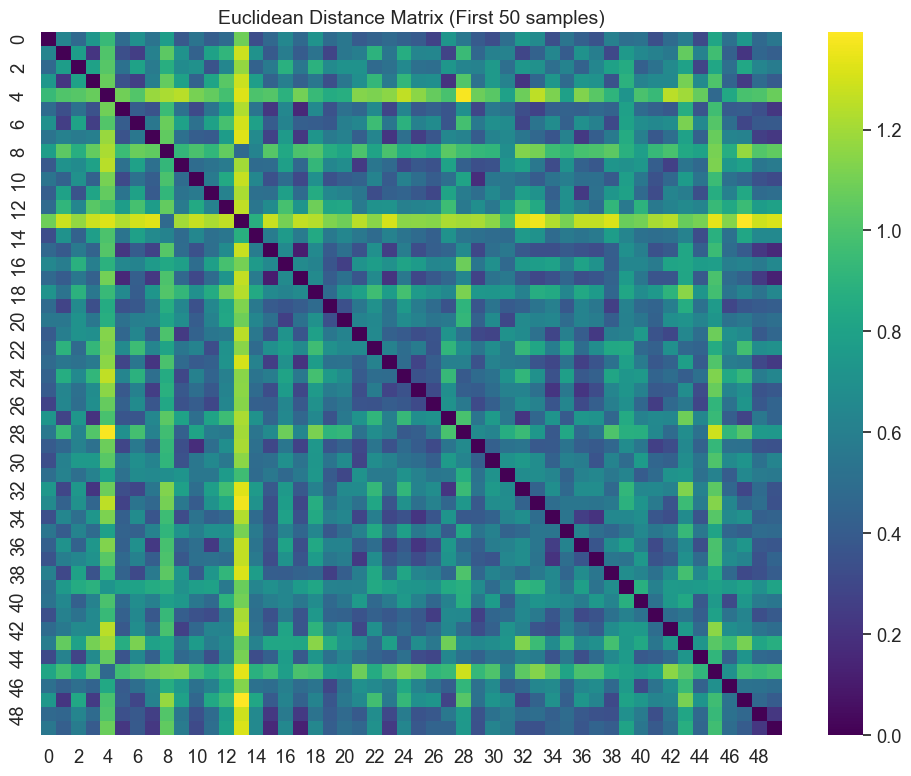

In [ ]:
# Calculate Euclidean distance matrix between all samples
distance_matrix = pairwise_distances(X, metric='euclidean')

# Display the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix[:50, :50], cmap='viridis')
plt.title('Euclidean Distance Matrix (First 50 samples)', fontsize=14)
plt.tight_layout()

### Step 2: Hierarchical Clustering (AGNES)

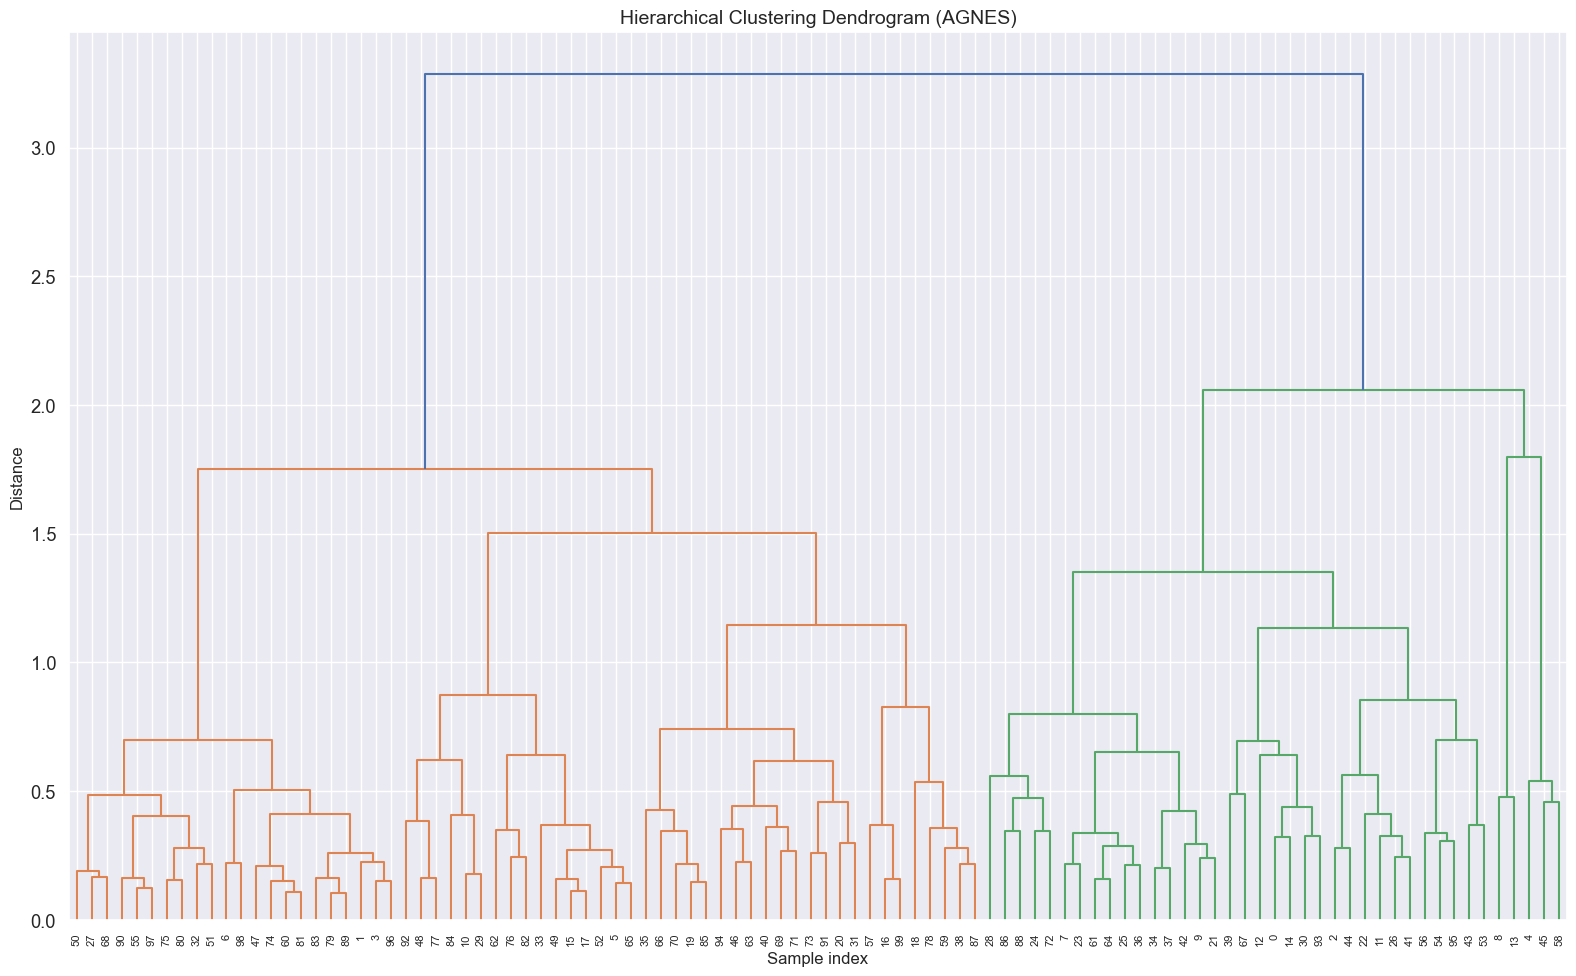

In [ ]:
# Draw dendrogram to observe hierarchical structure (with limited samples for clarity)
sample_size = 100
sampled_X = X[:sample_size]

# Calculate linkage matrix using Ward method
Z = linkage(sampled_X, 'ward')

plt.figure(figsize=(16, 10))
plt.title('Hierarchical Clustering Dendrogram (AGNES)', fontsize=14)
plt.xlabel('Sample index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.tight_layout()

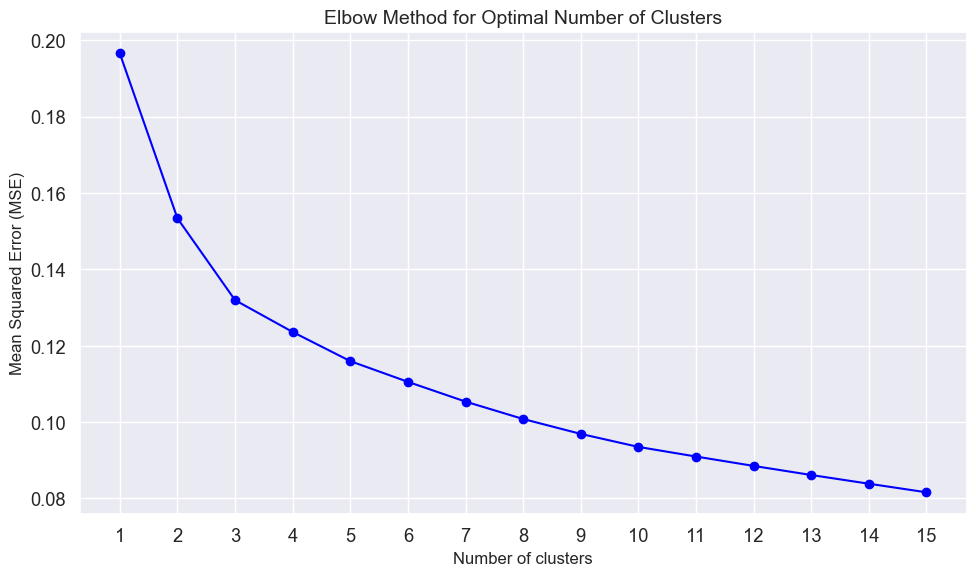

In [10]:
# Calculate MSE to determine optimal number of clusters
max_clusters = 15
mse_values = []

# Calculate MSE for different numbers of clusters
for n_clusters in range(1, max_clusters + 1):
    # If number of clusters is 1, we consider the mean of all data as the center
    if n_clusters == 1:
        centers = np.mean(X, axis=0).reshape(1, -1)
        cluster_labels = np.zeros(X.shape[0], dtype=int)
    else:
        # Run hierarchical clustering algorithm
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        cluster_labels = clustering.fit_predict(X)
        
        # Calculate cluster centers
        centers = np.zeros((n_clusters, X.shape[1]))
        for i in range(n_clusters):
            centers[i] = np.mean(X[cluster_labels == i], axis=0)
    
    # Calculate MSE for each sample relative to its cluster center
    mse = 0
    for i in range(X.shape[0]):
        cluster_idx = cluster_labels[i]
        mse += np.sum((X[i] - centers[cluster_idx]) ** 2)
    
    mse /= X.shape[0]
    mse_values.append(mse)

# Plot MSE to determine optimal number of clusters (Elbow method)
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), mse_values, 'o-', color='blue')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=14)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.grid(True)
plt.xticks(range(1, max_clusters + 1))
plt.tight_layout()

In [11]:
# Determine optimal number of clusters using second derivative of MSE
second_derivative = np.diff(np.diff(mse_values))
k_optimal = np.argmax(second_derivative) + 2

print(f"Optimal number of clusters based on Elbow method: {k_optimal}")

Optimal number of clusters based on Elbow method: 2


### Step 3: K-Means clustering using the optimal number of clusters

In [32]:
# بخش 3: خوشه‌بندی K-Means با استفاده از تعداد بهینه خوشه‌ها
# Part 3: K-Means clustering using the optimal number of clusters
# ====================================================================

# اجرای K-Means با تعداد بهینه خوشه‌ها
# Run K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, max_iter=300, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# محاسبه امتیاز سیلوئت برای ارزیابی کیفیت خوشه‌بندی
# Calculate silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(X, kmeans_labels)
print(f"میانگین امتیاز سیلوئت: {silhouette_avg:.4f}")
print(f"Average Silhouette Score: {silhouette_avg:.4f}")

میانگین امتیاز سیلوئت: 0.2688
Average Silhouette Score: 0.2688


In [34]:
# بررسی توزیع نمونه‌ها در خوشه‌ها
# Examine distribution of samples in clusters
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print("Number of samples in each cluster:")
for cluster_idx, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_idx}: {count} samples")

Number of samples in each cluster:
Cluster 0: 266 samples
Cluster 1: 502 samples


In [36]:
# افزودن برچسب‌های خوشه به دیتافریم اصلی
# Add cluster labels to the original dataframe
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = kmeans_labels

# تحلیل ویژگی‌های هر خوشه
# Analyze features of each cluster
cluster_stats = df_with_clusters.groupby('Cluster').mean()
print("\nمیانگین ویژگی‌ها در هر خوشه:")
print("Average features in each cluster:")
print(cluster_stats)


میانگین ویژگی‌ها در هر خوشه:
Average features in each cluster:
         Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Cluster                                                                  
0           0.425254  0.584550       0.544039       0.231612  0.100008   
1           0.120694  0.456741       0.467091       0.215421  0.095311   

              BMI  DiabetesPedigreeFunction       Age   Outcome  
Cluster                                                          
0        0.303727                  0.171733  0.414787  0.537594  
1        0.283337                  0.166296  0.092331  0.249004  


In [37]:
# بررسی توزیع افراد دیابتی و غیر دیابتی در خوشه‌ها
# Examine distribution of diabetic and non-diabetic individuals in clusters
diabetes_distribution = pd.crosstab(df_with_clusters['Cluster'], df_with_clusters['Outcome'])
diabetes_distribution.columns = ['غیر دیابتی (Non-Diabetic)', 'دیابتی (Diabetic)']
print("\nتوزیع افراد دیابتی و غیر دیابتی در خوشه‌ها:")
print("Distribution of diabetic and non-diabetic individuals in clusters:")
print(diabetes_distribution)


توزیع افراد دیابتی و غیر دیابتی در خوشه‌ها:
Distribution of diabetic and non-diabetic individuals in clusters:
         غیر دیابتی (Non-Diabetic)  دیابتی (Diabetic)
Cluster                                              
0                              123                143
1                              377                125


In [38]:
# محاسبه درصد افراد دیابتی در هر خوشه
# Calculate percentage of diabetic individuals in each cluster
diabetes_percentage = diabetes_distribution['دیابتی (Diabetic)'] / diabetes_distribution.sum(axis=1) * 100
diabetes_percentage.name = 'درصد افراد دیابتی (Percentage of Diabetics)'
print("\nدرصد افراد دیابتی در هر خوشه:")
print("Percentage of diabetic individuals in each cluster:")
print(diabetes_percentage)


درصد افراد دیابتی در هر خوشه:
Percentage of diabetic individuals in each cluster:
Cluster
0    53.759398
1    24.900398
Name: درصد افراد دیابتی (Percentage of Diabetics), dtype: float64


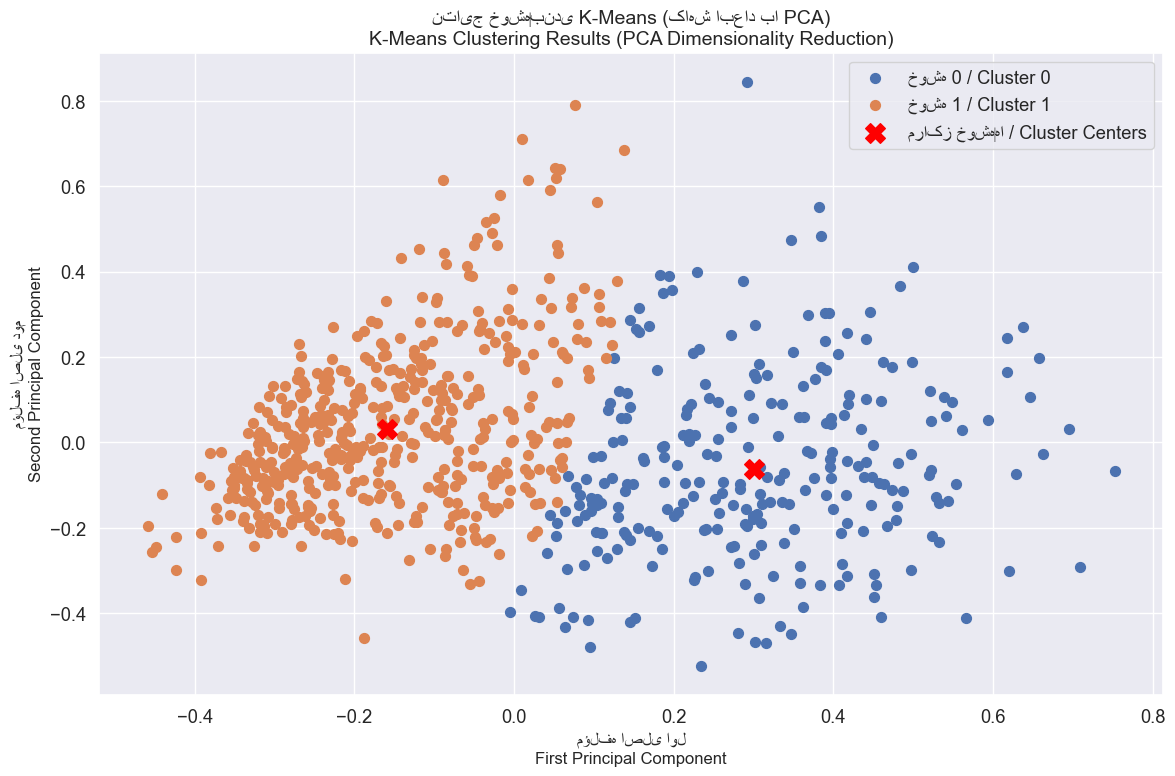

In [ ]:
# نمایش تصویری نتایج خوشه‌بندی با استفاده از کاهش ابعاد PCA
# Visual representation of clustering results using PCA dimensionality reduction
from sklearn.decomposition import PCA

# کاهش ابعاد به دو بعد برای نمایش تصویری
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ترسیم نتایج خوشه‌بندی
# Plot clustering results
plt.figure(figsize=(12, 8))
for i in range(k_optimal):
    plt.scatter(X_pca[kmeans_labels == i, 0], X_pca[kmeans_labels == i, 1], s=50, 
                label=f'خوشه {i} / Cluster {i}')

# نمایش مراکز خوشه‌ها در فضای PCA
# Display cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, marker='X', c='red', 
            label='مراکز خوشه‌ها / Cluster Centers')

plt.title('نتایج خوشه‌بندی K-Means (کاهش ابعاد با PCA)\nK-Means Clustering Results (PCA Dimensionality Reduction)', fontsize=14)
plt.xlabel('مؤلفه اصلی اول\nFirst Principal Component', fontsize=12)
plt.ylabel('مؤلفه اصلی دوم\nSecond Principal Component', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

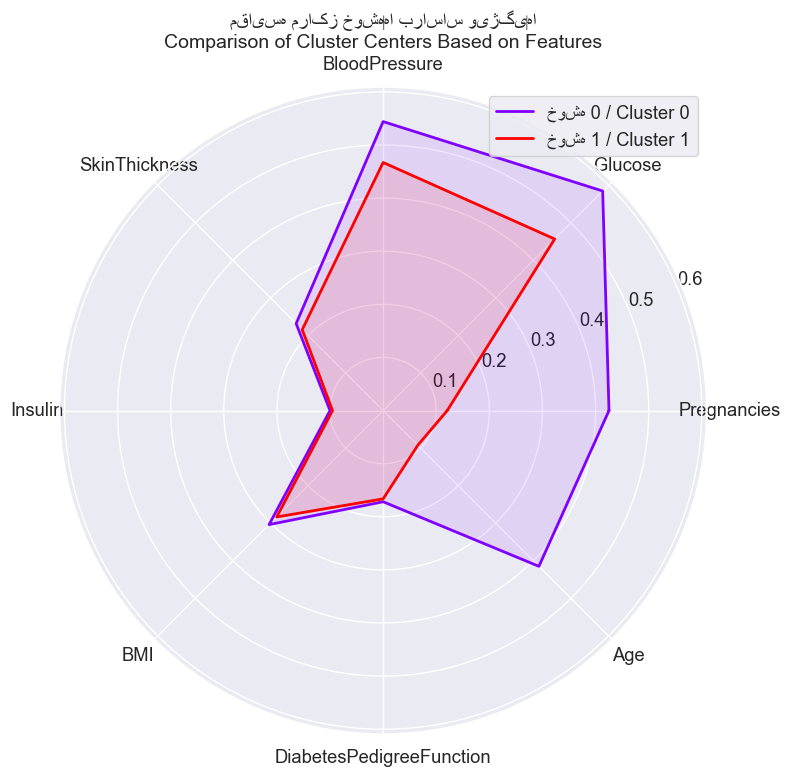

In [ ]:
# تحلیل ویژگی‌های مهم در هر خوشه با نمودار رادار
# Analyze important features in each cluster with radar chart
from math import pi

# استخراج ویژگی‌های مرکز هر خوشه
# Extract features of each cluster center
centers = kmeans.cluster_centers_

# رسم نمودار رادار برای مقایسه ویژگی‌ها در هر خوشه
# Draw radar chart to compare features in each cluster
def radar_chart(centers, feature_names):
    # تعداد ویژگی‌ها
    # Number of features
    N = len(feature_names)
    
    # محاسبه زاویه برای هر ویژگی
    # Calculate angle for each feature
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # بستن دایره / Close the circle
    
    # ایجاد نمودار
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
    
    # رنگ‌های متنوع برای هر خوشه
    # Various colors for each cluster
    colors = cm.rainbow(np.linspace(0, 1, len(centers)))
    
    # رسم داده‌ها برای هر خوشه
    # Plot data for each cluster
    for i, center in enumerate(centers):
        values = list(center)
        values += values[:1]  # بستن دایره / Close the circle
        ax.plot(angles, values, color=colors[i], linewidth=2, label=f'خوشه {i} / Cluster {i}')
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    # برچسب‌ها و عنوان
    # Labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names)
    plt.title('مقایسه مراکز خوشه‌ها براساس ویژگی‌ها\nComparison of Cluster Centers Based on Features', size=14)
    ax.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    
# گرفتن نام‌های ویژگی‌ها (همه ستون‌ها به جز آخرین ستون که برچسب هدف است)
# Get feature names (all columns except the last one which is the target label)
feature_names = df.columns[:-1].tolist()

# رسم نمودار رادار
# Draw radar chart
radar_chart(centers, feature_names)

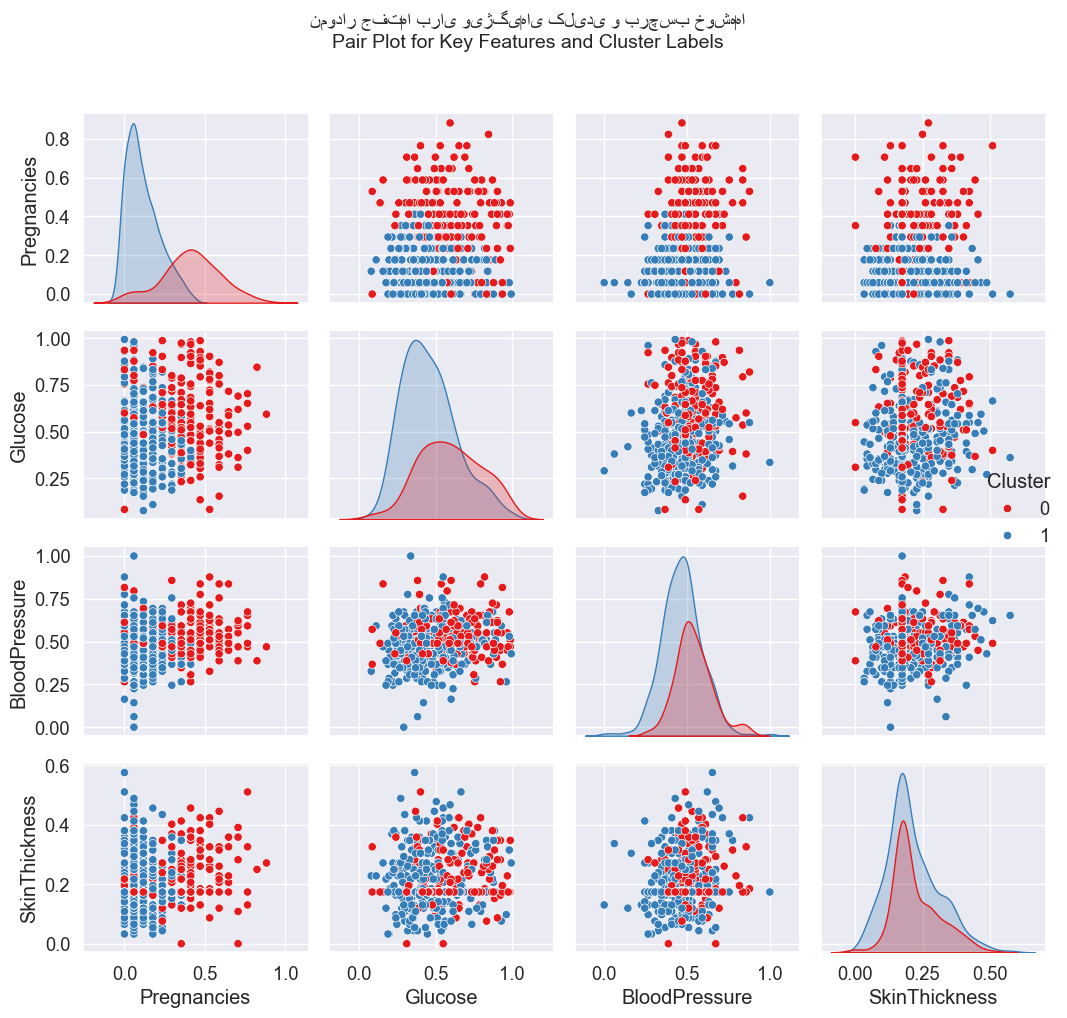

In [48]:
# ارتباط بین ویژگی‌ها و برچسب خوشه‌ها با نمودار جفت‌ها
# Relationship between features and cluster labels with pair plot
# انتخاب تصادفی بخشی از داده‌ها برای نمودار جفت‌ها (برای سرعت بیشتر)
# Randomly select a subset of data for pair plot (for better speed)
sample_idx = np.random.choice(len(df_with_clusters), size=min(500, len(df_with_clusters)), replace=False)
df_sample = df_with_clusters.iloc[sample_idx]

# انتخاب ویژگی‌های مهم براساس تأثیر در خوشه‌بندی
# Select important features based on impact on clustering
# اگر تعداد ویژگی‌ها زیاد است، فقط تعدادی از آن‌ها را انتخاب می‌کنیم
# If there are many features, we select only some of them
if len(feature_names) > 4:
    # مثال: انتخاب 4 ویژگی اول
    # Example: select the first 4 features
    selected_features = feature_names[:4]
else:
    selected_features = feature_names

sns.pairplot(df_sample, vars=selected_features, hue='Cluster', palette='Set1', diag_kind='kde', height=2.5)
plt.suptitle('نمودار جفت‌ها برای ویژگی‌های کلیدی و برچسب خوشه‌ها\nPair Plot for Key Features and Cluster Labels', y=1.02, fontsize=14)
plt.tight_layout()